In [1]:
from typing import List
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_loader import (
    load_mergesort_results,
    load_radixsort_results,
)

In [2]:
ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR / 'data'

In [3]:
MERGE_SORT_DIR = DATA_DIR / 'mergeSortResults'
RADIX_SORT_DIR = DATA_DIR / 'radixSortResults'

In [114]:
def show(df: pd.DataFrame, lines: int = 5) -> None:
    display(df.head(lines))
    print(f"Shape: {df.shape}")


def aggregate_data(
    df: pd.DataFrame,
    groupby_columns: List[str],
    round_to: int = 0,
) -> pd.DataFrame:
    """Compute the mean time for each group of experiments,
    std and confidence interval.
    Args:
        df: DataFrame with the data
        groupby_columns: Columns to group by
    Returns:
        DataFrame with the mean time for each group of experiments
    """
    means = df.groupby(groupby_columns).agg(
        mean_time=("time", "mean"),
        std_time=("time", "std"),
        ci_time=("time", lambda x: 1.96 * np.std(x) / np.sqrt(len(x))),
    )

    means["ci_time"] = means.apply(
        lambda x: (
            round(x["mean_time"] - x["ci_time"], round_to),
            round(x["mean_time"] + x["ci_time"], round_to),
        ),
        axis=1,
    )

    means = means.round(round_to)
    if round_to == 0:
        means["mean_time"] = means["mean_time"].astype(int)
        means["std_time"] = means["std_time"].astype(int)
        means["ci_time"] = means["ci_time"].apply(lambda x: (int(x[0]), int(x[1])))
    return means.reset_index()


def get_optimal_bucket_size(
    radix_df: pd.DataFrame,
    time_column: str = "time",
) -> pd.DataFrame:
    """Returns a dataframe with the optimal bucket size for each universe."""
    min_time_index = radix_df.groupby("universe")[time_column].idxmin()
    return radix_df.loc[min_time_index].reset_index(drop=True)

In [109]:
FIRST_EXPERIMENT = 101
MAX_BUCKET_SIZE = 28

mergesort = load_mergesort_results(MERGE_SORT_DIR)
mergesort = mergesort[mergesort["experiment"] >= FIRST_EXPERIMENT]

radixsort = load_radixsort_results(RADIX_SORT_DIR)
radixsort = radixsort[
    (radixsort["experiment"] >= FIRST_EXPERIMENT)
    & (radixsort["bucket_size"] <= MAX_BUCKET_SIZE)
]

In [110]:
ROUND_TO = 0

mergesort = aggregate_data(
    mergesort,
    groupby_columns=["universe"],
    round_to=ROUND_TO,
)

radixsort = aggregate_data(
    radixsort,
    groupby_columns=["universe", "bucket_size"],
    round_to=ROUND_TO,
)

In [111]:
show(mergesort)
show(radixsort)

,universe,mean_time,std_time,ci_time
0,1,3217,14,"(3208, 3226)"
1,2,3390,18,"(3378, 3403)"
2,3,3490,21,"(3475, 3505)"
3,4,3563,17,"(3551, 3574)"
4,5,3633,20,"(3619, 3646)"


Shape: (64, 4)


,universe,bucket_size,mean_time,std_time,ci_time
0,1,1,549,17,"(537, 560)"
1,2,1,788,23,"(773, 804)"
2,2,2,545,14,"(535, 555)"
3,3,1,1035,31,"(1014, 1056)"
4,3,2,548,16,"(537, 558)"


Shape: (1414, 5)


In [116]:
mergesort

,universe,mean_time,std_time,ci_time
0,1,3217,14,"(3208, 3226)"
1,2,3390,18,"(3378, 3403)"
2,3,3490,21,"(3475, 3505)"
3,4,3563,17,"(3551, 3574)"
4,5,3633,20,"(3619, 3646)"
...,...,...,...,...
59,60,4392,10,"(4385, 4400)"
60,61,4396,17,"(4384, 4408)"
61,62,4391,9,"(4384, 4397)"
62,63,4404,24,"(4385, 4424)"


In [121]:
radixsort.sort_values("mean_time").head(50)

,universe,bucket_size,mean_time,std_time,ci_time
2,2,2,545,14,"(535, 555)"
4,3,2,548,16,"(537, 558)"
0,1,1,549,17,"(537, 560)"
12,5,3,551,17,"(539, 563)"
13,5,4,552,13,"(543, 561)"
8,4,3,553,17,"(541, 565)"
24,7,4,554,16,"(543, 565)"
18,6,4,555,18,"(543, 567)"
5,3,3,555,15,"(545, 566)"
9,4,4,561,19,"(548, 574)"


In [137]:
mergesort = mergesort.sort_values("universe")
optimal_radix = get_optimal_bucket_size(radixsort, time_column="mean_time")
optimal_radix = optimal_radix.sort_values("universe")

In [138]:
# optimal_radix.sort_values("universe").tail(60)

<Axes: xlabel='universe', ylabel='bucket_size'>

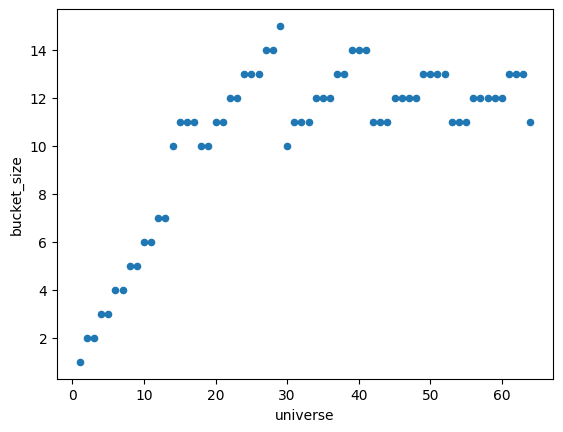

In [133]:
optimal_radix.plot(x="universe", y="bucket_size", kind="scatter")

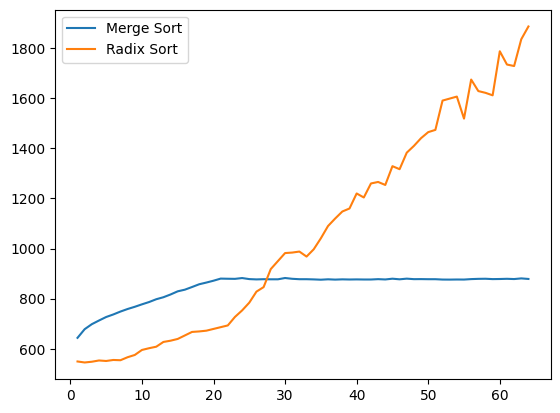

In [155]:
plt.plot(mergesort["universe"], mergesort["mean_time"], label="Merge Sort")
plt.plot(optimal_radix["universe"], optimal_radix["mean_time"], label="Radix Sort")
plt.legend();